In [1]:
import sys
import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

sys.path.append(os.getcwd())
from load_data import *
from plotting_tools import *

sys.path.append('../3_score/')
from optimize import Scores
from fingerprint import FuzzyFingerPrint

Loading crystal structures...
Loading glidescores...
0 of 28 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
pdbbind_final/P61823, 1RPF: 27 ligands docked well


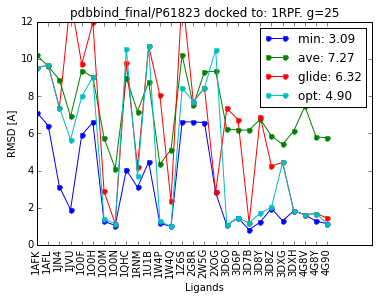

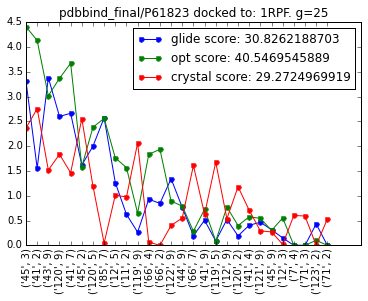

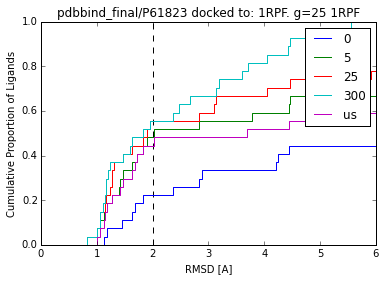

1RPF performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|3.09|7.27|3.69|6.89|4.90|6.32|0.44|0.22|
new worst! pdbbind_final/P61823 1RPF: us=0.444444444444 glide=0.222222222222
pdbbind_final/P61823, 1RPF: 27 ligands docked well


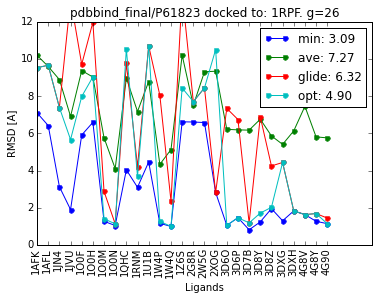

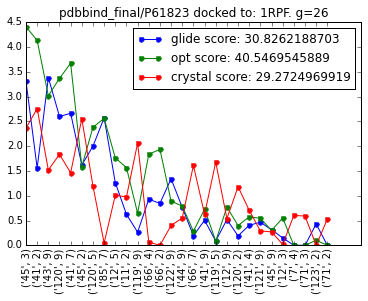

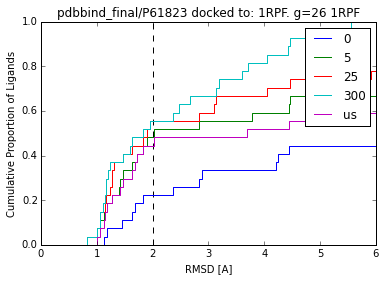

1RPF performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|3.09|7.27|3.69|6.89|4.90|6.32|0.44|0.22|
pdbbind_final/P61823, 1RPF: 27 ligands docked well


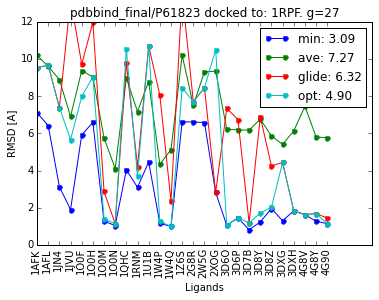

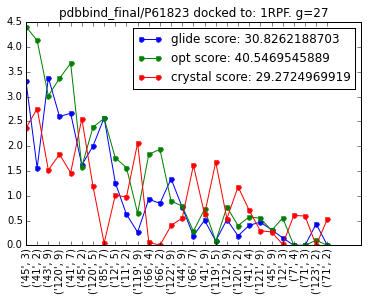

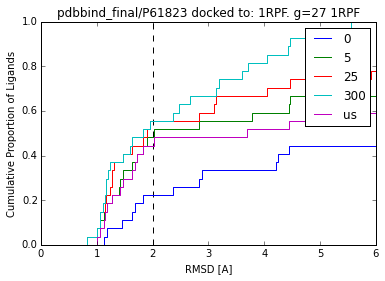

1RPF performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|3.09|7.27|3.69|6.89|4.90|6.32|0.44|0.22|
pdbbind_final/P61823, 1RPF: 27 ligands docked well


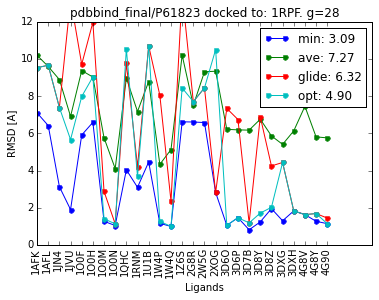

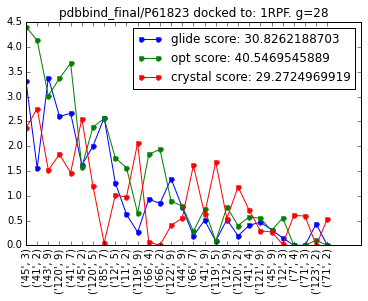

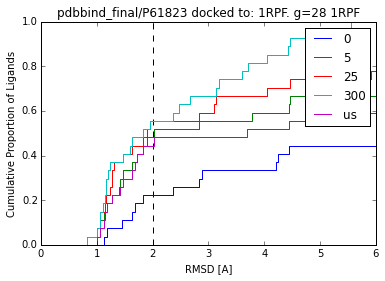

1RPF performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|3.09|7.27|3.69|6.89|4.90|6.32|0.44|0.22|
pdbbind_final/P61823, 1RPF: 27 ligands docked well


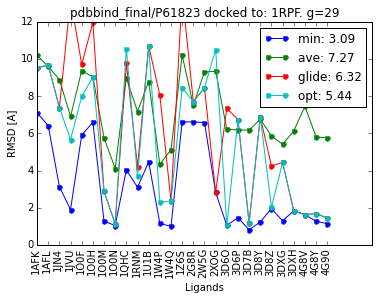

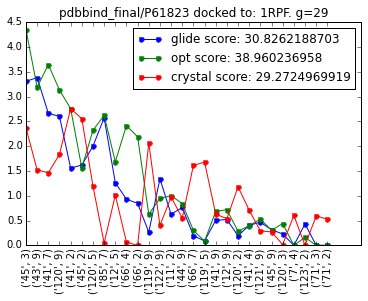

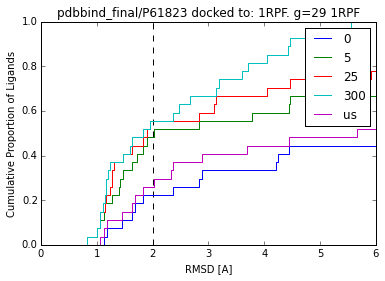

1RPF performance:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|3.09|7.27|5.66|6.89|5.44|6.32|0.25|0.22|
new worst! pdbbind_final/P61823 1RPF: us=0.259259259259 glide=0.222222222222
summary of all data:
| min | ave | us (median) | glide (median) | us (ave) | glide (ave) | us (<2) | glide (<2)|
|3.09|7.27|3.69|6.89|5.01|6.32|0.40|0.22|
overall worst: pdbbind_final/P61823 1RPF: glide - us=-0.037037037037


In [2]:
get_ipython().magic(u'matplotlib inline')

worst_dataset, worst_struct, worst_metric = (None, None, -1)
all_final = {}

all_r = ['pdbbind_final/{}'.format(r) for r in os.listdir('/scratch/PI/rondror/docking_data/pdbbind_final')]
all_r.sort(key=lambda x:len(os.listdir('/scratch/PI/rondror/docking_data/{}/unique_ligands'.format(x))))

grids = {}
with open('/scratch/PI/rondror/docking_data/pdbbind_first_grids.txt') as f:
    for line in f:
        r, g = line.strip().split()
        grids['pdbbind_final/'+r] = g

for receptor in ['pdbbind_final/P61823']:
#for receptor in all_r:
    
    (xcrystals, xglides, ligs, structs) = load_data(receptor,
                                                    w=[0,0,10,10,10,5,10,10,10,0.2,0,0,0],
                                                    require_fp=True,
                                                    combine_structs=False, 
                                                    glide_ifp='ifp/xglide_5',
                                                    crystal_ifp='ifp/xcrystal6',
                                                    load_docking=True)
    s = '1RPF'
    #g = 20
    for g in [25,26,27,28,29]:
    #for s in ['1RPF']:
    #s = grids[receptor]
    #for s in os.listdir('/scratch/PI/rondror/docking_data/{}/grids'.format(receptor)):
        rmsds = [min([xglides[l][s].poses[i].rmsd 
                      for i in range(min(25, max(xglides[l][s].poses.keys()))+1)]) 
                 if s in xglides[l] else 10 for l in ligs]
        filt_lig = [l for i, l in enumerate(ligs) if l != s] # rmsds[i] <= 2 and 

        print '{}, {}: {} ligands docked well'.format(receptor, s, len(filt_lig))
        if len(filt_lig) < 10: continue

        scores = Scores(xglides, xcrystals, filt_lig, s, 25, gscore_weight=g)
        title = '{} docked to: {}. g={}'.format(receptor, s, g)
        final_rmsds = plot_final_rmsds(scores, title)

        plot_shared_interactions(scores, max_r=20, title=title)

        a = scores.all_analysis
        plot_docking_by_structure(filt_lig, s, xglides, n_list=[0,5,25,300], title=title, us_rmsds=a['opt'][1][:])
        print s, 'performance:'
        print_table({i:a[i][1][:] for i in a})
        for i in a:
            if i not in all_final: all_final[i] = []
            all_final[i].extend(a[i][1][:])

        us_success = sum([1.0/len(a['opt'][1][:]) for i in a['opt'][1] if i <= 2.0])
        glide_success = sum([1.0/len(a['glide'][1][:]) for i in a['glide'][1] if i <= 2.0])
        perf = glide_success - us_success
        if perf > worst_metric:
            print 'new worst! {} {}: us={} glide={}'.format(receptor, s, us_success, glide_success)
            worst_dataset, worst_struct, worst_metric = receptor, s, perf
           
print 'summary of all data:'
print_table(all_final)
print 'overall worst: {} {}: glide - us={}'.format(worst_dataset, worst_struct, worst_metric)